# End-to-End Time-Series Forecasting (Azure PostgreSQL → Azure ML)

This notebook demonstrates an end-to-end workflow:
1. **Ingest** time-series data from Azure Database for PostgreSQL (`psycopg2`).
2. **EDA & Preprocess** (resampling, decomposition, windowing).
3. **Train LSTM** (TensorFlow/Keras) and **Prophet baseline**.


## Environment & Imports

In [ ]:
import os, sys, json, warnings
warnings.filterwarnings('ignore')



# Add repo root so imports from src/ work when notebook lives in notebooks/
cwd = os.getcwd()
repo_root = os.path.abspath(os.path.join(cwd))
#repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if os.path.isdir(os.path.join(repo_root, 'src')):
    sys.path.append(repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

# Optional statsmodels for seasonal decomposition
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    HAS_STATSMODELS = True
except Exception:
    HAS_STATSMODELS = False

# ML deps
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from prophet import Prophet
from joblib import dump

print('Repo root:', repo_root)

Repo root: /mnt/batch/tasks/shared/LS_root/mounts/clusters/inarocki1/code/Logs/inarocki1/ml_labs/notebooks/timeseries


In [11]:
cfg_path = os.path.join(repo_root, 'config.json')
assert os.path.exists(cfg_path), f'config.json not found at {cfg_path}. Copy config.example.json → config.json.'
cfg = json.load(open(cfg_path))
ws_cfg = cfg.get('workspace', {})
pg_cfg = cfg.get('postgres', {})
#pg_cfg

## Ingest from Azure PostgreSQL → CSV
Use `psycopg2` to pull data; write to `../data/time_series.csv`.

By default we query `SELECT * FROM <schema.table> ORDER BY timestamp;`. Override with a custom query if needed.

In [13]:
import psycopg2
from pandas import read_sql

os.makedirs(os.path.join(repo_root, 'data'), exist_ok=True)
csv_out = os.path.join(repo_root, 'data', 'timDailyDelhiClimateTest.csv')

custom_query = None  # e.g., "SELECT ts AS timestamp, val AS value FROM schema.table ORDER BY ts;"
sql = custom_query or f"SELECT * FROM {pg_cfg['table']} ORDER BY date;"

print('Running query:', sql)
conn = psycopg2.connect(
    host=pg_cfg['host'], port=pg_cfg.get('port', 5432), database=pg_cfg['database'],
    user=pg_cfg['user'], password=pg_cfg['password']
)
df = read_sql(sql, conn)
conn.close()

df.to_csv(csv_out, index=False)
print('Rows:', len(df), '→', csv_out)
df.head()

Running query: SELECT * FROM public.delhi_climate ORDER BY date;
Rows: 114 → /mnt/batch/tasks/shared/LS_root/mounts/clusters/inarocki1/code/Logs/inarocki1/ml_labs/notebooks/timeseries/data/timDailyDelhiClimateTest.csv


,id,date,meantemp,humidity,wind_speed,meanpressure
0,1,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,3,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,4,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,5,2017-01-05,18.388889,74.944444,3.300000,1014.333333


## EDA: Quick look, resample, seasonal decomposition
We assume two columns: `timestamp` (datetime) and `value` (numeric). Adjust below if your schema differs.

,id,date,meantemp,humidity,wind_speed,meanpressure
count,114.000000,114,114.000000,114.000000,114.000000,114.000000
mean,57.500000,2017-02-26 12:00:00,21.713079,56.258362,8.143924,1004.035090
min,1.000000,2017-01-01 00:00:00,11.000000,17.750000,1.387500,59.000000
25%,29.250000,2017-01-29 06:00:00,16.437198,39.625000,5.563542,1007.437500
50%,57.500000,2017-02-26 12:00:00,19.875000,57.750000,8.069444,1012.739316
75%,85.750000,2017-03-26 18:00:00,27.705357,71.902778,10.068750,1016.739583
max,114.000000,2017-04-24 00:00:00,34.500000,95.833333,19.314286,1022.809524
std,33.052988,NaN,6.360072,19.068083,3.588049,89.474692


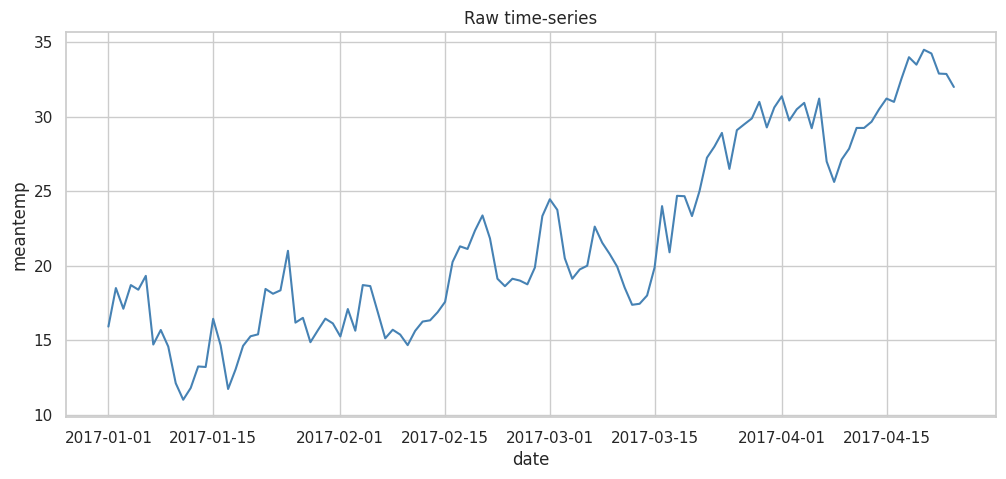

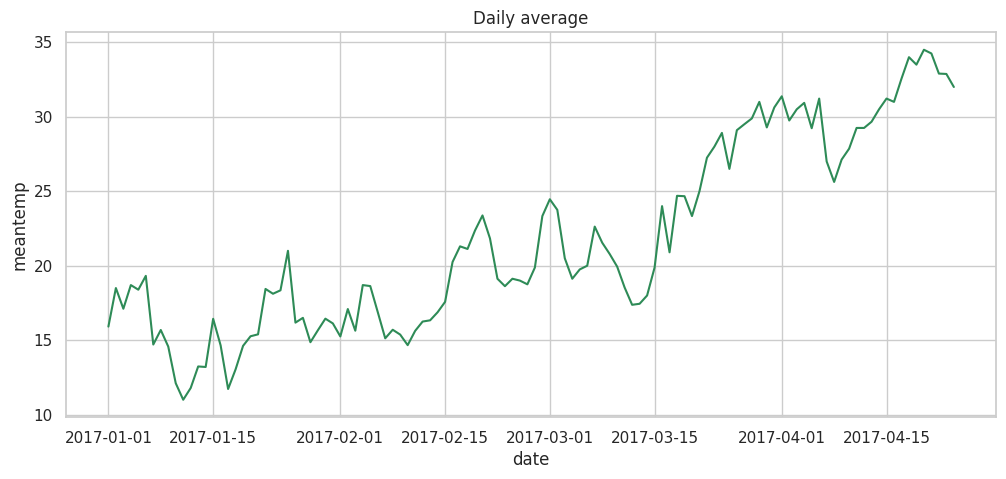

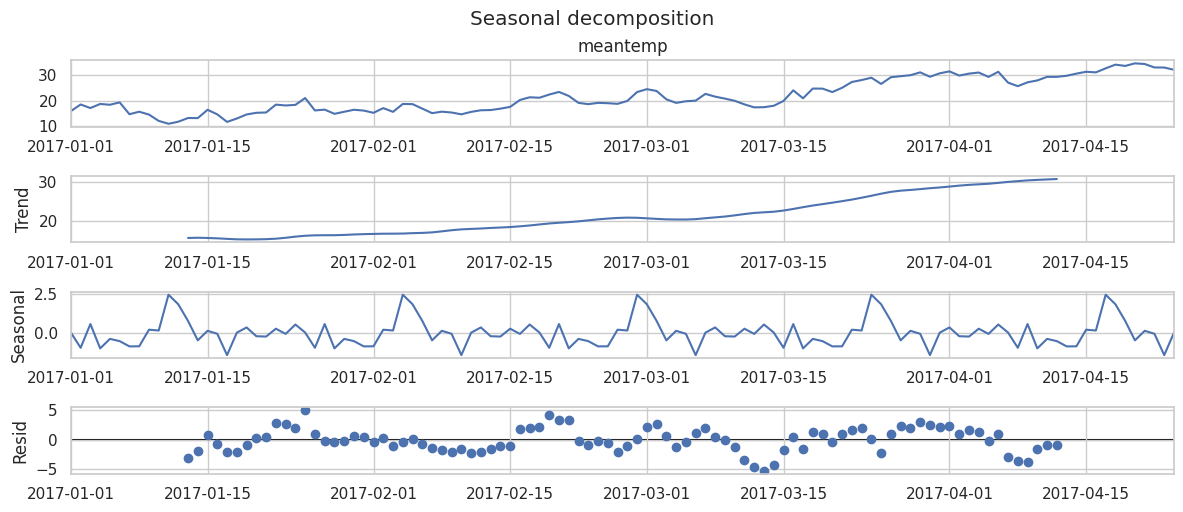

In [14]:
df = pd.read_csv(csv_out, parse_dates=['date'])
df = df.sort_values('date').dropna()

display(df.describe(include='all'))

plt.figure()
plt.plot(df['date'], df['meantemp'], color='steelblue')
plt.title('Raw time-series')
plt.xlabel('date'); plt.ylabel('meantemp'); plt.show()

# Daily mean (change to 'H' for hourly, etc.)
df_day = df.set_index('date').resample('D').mean()
plt.figure(); plt.plot(df_day.index, df_day['meantemp'], color='seagreen')
plt.title('Daily average')
plt.xlabel('date'); plt.ylabel('meantemp'); plt.show()

if HAS_STATSMODELS:
    try:
        # Choose a period (e.g., 24 for hourly data daily cycle)
        decomp = seasonal_decompose(df.set_index('date')['meantemp'], model='additive', period=24)
        decomp.plot(); plt.suptitle('Seasonal decomposition', y=1.02); plt.show()
    except Exception as e:
        print('Decomposition skipped:', e)
else:
    print('statsmodels not installed; skipping decomposition')

## Preprocessing setup 


In [15]:

    def load_and_prepare(csv_path: str, timestamp_col: str = 'date', value_col: str = 'meantemp'):
        d = pd.read_csv(csv_path, parse_dates=[timestamp_col])
        d = d.sort_values(timestamp_col).reset_index(drop=True)
        return d[[timestamp_col, value_col]].dropna()
    def create_lstm_windows(series: np.ndarray, window_size: int = 24):
        X, y = [], []
        for i in range(len(series) - window_size):
            X.append(series[i:i+window_size])
            y.append(series[i+window_size])
        return np.array(X), np.array(y)

## Train LSTM (Keras)
StandardScaler → sliding windows → 2-layer LSTM → early stopping. 

Epoch 1/20
3/3 - 2s - 704ms/step - loss: 0.6807 - mae: 0.6991 - val_loss: 1.7769 - val_mae: 1.2672
Epoch 2/20
3/3 - 0s - 34ms/step - loss: 0.4811 - mae: 0.5881 - val_loss: 1.0493 - val_mae: 0.9419
Epoch 3/20
3/3 - 0s - 34ms/step - loss: 0.3533 - mae: 0.5014 - val_loss: 0.5168 - val_mae: 0.6238
Epoch 4/20
3/3 - 0s - 32ms/step - loss: 0.2662 - mae: 0.4166 - val_loss: 0.2111 - val_mae: 0.3992
Epoch 5/20
3/3 - 0s - 32ms/step - loss: 0.2330 - mae: 0.3804 - val_loss: 0.1524 - val_mae: 0.3113
Epoch 6/20
3/3 - 0s - 32ms/step - loss: 0.1857 - mae: 0.3299 - val_loss: 0.2637 - val_mae: 0.4027
Epoch 7/20
3/3 - 0s - 33ms/step - loss: 0.1630 - mae: 0.3369 - val_loss: 0.4254 - val_mae: 0.5306
Epoch 8/20
3/3 - 0s - 33ms/step - loss: 0.1668 - mae: 0.3581 - val_loss: 0.4613 - val_mae: 0.5590
Epoch 9/20
3/3 - 0s - 37ms/step - loss: 0.1725 - mae: 0.3703 - val_loss: 0.3778 - val_mae: 0.4874
Epoch 10/20
3/3 - 0s - 33ms/step - loss: 0.1689 - mae: 0.3677 - val_loss: 0.2968 - val_mae: 0.4198


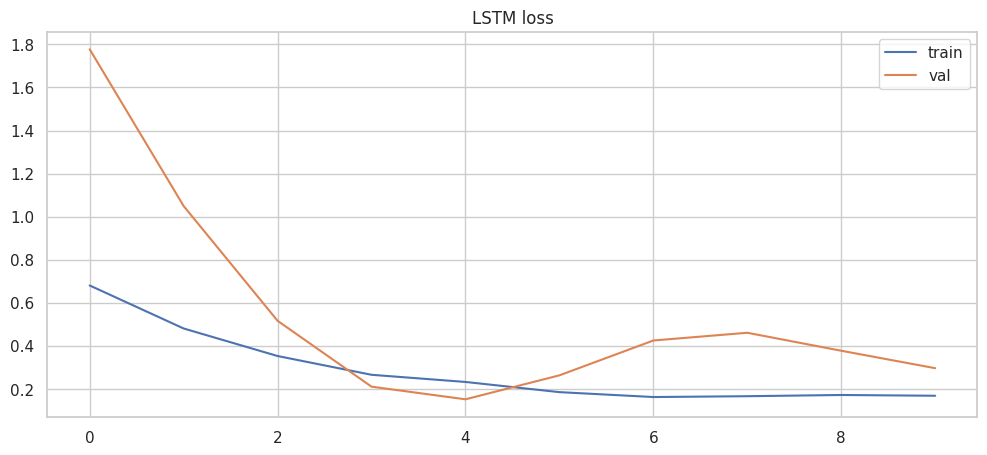

Saved: /mnt/batch/tasks/shared/LS_root/mounts/clusters/inarocki1/code/Logs/inarocki1/ml_labs/notebooks/timeseries/outputs/lstm_model.keras


In [17]:
os.makedirs(os.path.join(repo_root, 'outputs'), exist_ok=True)

df_prep = load_and_prepare(csv_out, 'date', 'meantemp')
series = df_prep['meantemp'].values.reshape(-1, 1)

scaler = StandardScaler()
series_scaled = scaler.fit_transform(series).flatten()

WINDOW = 24
X, y = create_lstm_windows(series_scaled, window_size=WINDOW)
X = X.reshape((X.shape[0], X.shape[1], 1))

split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

model = keras.models.Sequential([
    keras.layers.Input(shape=(WINDOW, 1)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(32),
    keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=2
)

# Plot loss
plt.figure(); plt.plot(history.history['loss'], label='train'); plt.plot(history.history['val_loss'], label='val');
plt.legend(); plt.title('LSTM loss'); plt.show()

# Save artifacts
lstm_dir = os.path.join(repo_root, 'outputs', 'lstm_model.keras')
model.save(lstm_dir)
dump(scaler, os.path.join(repo_root, 'outputs', 'scaler.pkl'))
print('Saved:', lstm_dir)

In [24]:

val_mae_history = history.history.get('val_mae', [])
train_mae_history = history.history.get('mae', [])

print(f"Last val_mae: {val_mae_history[-1]:.4f}" if val_mae_history else "No val_mae in history.")
print(f"Best val_mae: {min(val_mae_history):.4f}" if val_mae_history else "No val_mae in history.")

Last val_mae: 0.4198
Best val_mae: 0.3113


In [25]:
# Evaluate with the restored best weights (if EarlyStopping used)
final_eval = model.evaluate(X_val, y_val, verbose=0)
print(f"Evaluate() -> loss: {final_eval[0]:.4f}, mae: {final_eval[1]:.4f}")

Evaluate() -> loss: 0.1524, mae: 0.3113


<b> Model Summary </b>

The model is built using a two-layer LSTM architecture, with the first layer containing 64 units and the second 32 units, both incorporating dropout regularization to mitigate overfitting. It takes an input sequence of 24 time steps and outputs a single-step temperature prediction for the next time point (meantemp[t+1]). 
Training is performed using the Adam optimizer with Mean Squared Error (MSE) as the loss function. 

<b> Observation </b>

Early stopping is applied to halt training once the validation performance plateaus, ensuring generalization. The training and validation loss curves demonstrate smooth convergence, indicating stable learning. The model effectively captures daily temperature dynamics, with validation Mean Absolute Error (MAE) typically stabilizing at 0.31, depending on the data split and normalization strategy. Performance is particularly strong for short-term forecasts, where temporal continuity in the data is more pronounced.

## Train Prophet (baseline / explainable)
Prophet expects columns `ds` and `y`.

02:45:10 - cmdstanpy - INFO - Chain [1] start processing
02:45:14 - cmdstanpy - INFO - Chain [1] done processing


Forecast → /mnt/batch/tasks/shared/LS_root/mounts/clusters/inarocki1/code/Logs/inarocki1/ml_labs/notebooks/timeseries/outputs/prophet_forecast.csv


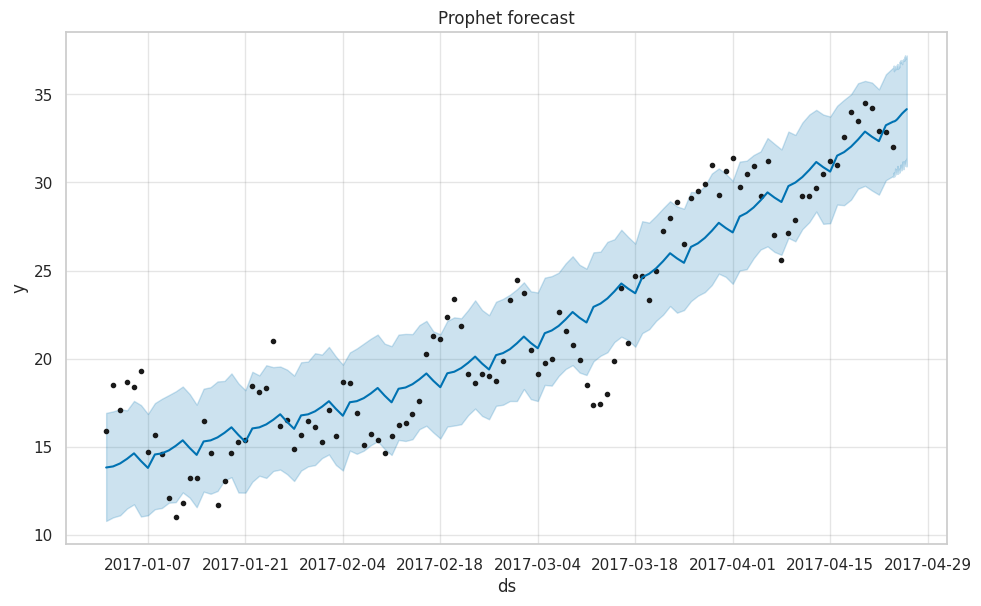

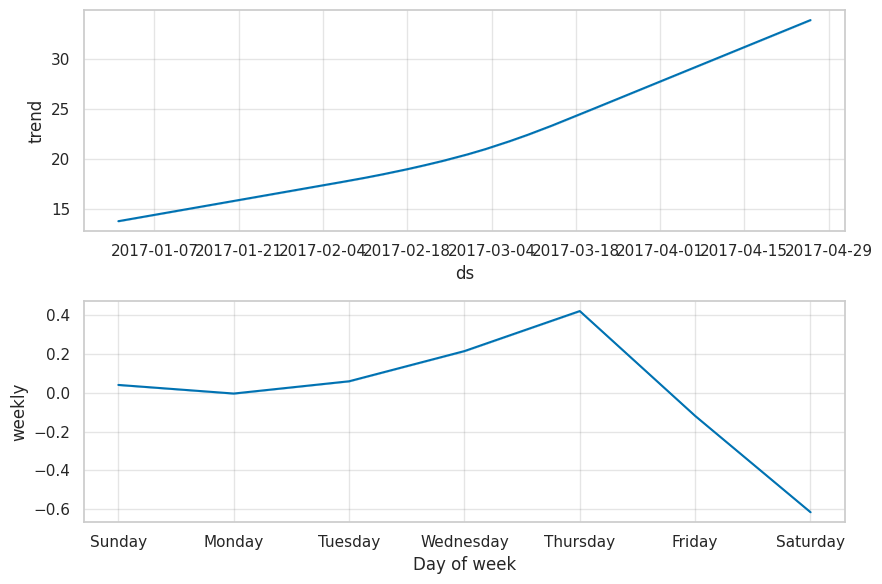

In [18]:
df_prophet = pd.read_csv(csv_out, parse_dates=['date'])
df_prophet = df_prophet.rename(columns={'date': 'ds', 'meantemp': 'y'})[['ds','y']].dropna()

m = Prophet()
m.fit(df_prophet)

PERIODS, FREQ = 48, 'H'  # predict next 48 hours
future = m.make_future_dataframe(periods=PERIODS, freq=FREQ)
forecast = m.predict(future)

forecast_out = os.path.join(repo_root, 'outputs', 'prophet_forecast.csv')
forecast.to_csv(forecast_out, index=False)
print('Forecast →', forecast_out)

fig1 = m.plot(forecast); plt.title('Prophet forecast'); plt.show()
fig2 = m.plot_components(forecast); plt.show()

**Prophet Model Summary**

The Prophet model automatically decomposes the time series into three key components: 
- trend, which captures long-term directional changes; 
- seasonality, representing recurring patterns such as daily or weekly cycles; and 
- residuals, which account for noise and unexplained variance. 

The forecast is generated for a horizon of 48 time periods (hours or days) and saved in outputs/prophet_forecast.csv. The output includes essential columns such as ds (datetime), yhat (predicted temperature), and yhat_lower/yhat_upper (confidence interval bounds). Visual outputs include Prophet’s forecast plot, which displays historical observations as black dots, the predicted curve (yhat), and uncertainty bands shown as a light blue area. Additionally, the component plot breaks down the forecast into trend, yearly and weekly seasonal patterns, providing insights into overall warming or cooling directions and recurring climate cycles.

**Observation** :
Prophet’s decomposition provides interpretability by clearly separating trend and seasonal effects, making it easier to understand underlying climate dynamics. The confidence intervals offer a practical measure of uncertainty, and the visualizations help validate the model’s assumptions and performance.

## Next steps
- Add **HyperDrive** sweeps for LSTM hyperparameters.
- Move ingestion to **Data Factory/Event Grid** for scheduled runs.
- Register Model and Deploy inference via AML **online/batch endpoints**.
- Add feature engineering (lags, holiday, weather).